V tomto notebooku vytvarame 2 rozne stromy pomocou kniznice scikit-learn, pricom jednotlive stromy pracuju s roznymi datami, pri ktorych boli pouzite ine strategie nahradzania chybajucich hodnot. Na prvych datach sme pouzili len strategiu nahradzovania hodnot KNN pre numericke hodnoty a na druhych datach sme pouzili len strategiu mean nad numerickymi hodnotami. Nasledne skumame vysledky tychto troch (povodny - KNN a MissForest, KNN a mean) a porovnavame ich medzi sebou.

In [15]:
import scipy.stats as stats
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute._iterative import IterativeImputer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser as parser
from sklearn.impute import SimpleImputer as Imputer, SimpleImputer
from sklearn.neighbors import NearestNeighbors as neigh
from sklearn.neighbors import KNeighborsRegressor as neigh
from sklearn.model_selection import train_test_split as split
from sklearn import metrics
from math import sqrt
import json
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from missingpy import KNNImputer, MissForest
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
import copy
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

Tato cast je skopirovane vytvorenie stromu z notebooku 'DecisionTreeClassifier'. Pricom jediny rozdiel je to, ze nacitavame ine subory, ktore sme si dobredu pripravili. V tomto pripade nacitavame data, ktorych chybajuce hodnoty (NaN) boli pri numerickych hodnotach nahradene algoritmom KNN.

In [16]:
merged_data = pd.read_csv('trained_datas_KNN.csv',index_col=0)
# merged_data.info()
merged_data = merged_data.drop(['name', 'address', 'date_of_birth'], axis = 1)
categoric = merged_data.select_dtypes(include = ['object'])

encoder = ce.OneHotEncoder()
encoder.fit(categoric)
transformed = encoder.transform(categoric)

merged_data = merged_data.drop(categoric, axis = 1)
merged_data = merged_data.merge(transformed, left_index=True, right_index=True)
merged_data

,education-num,capital-gain,fnlwgt,hours-per-week,capital-loss,kurtosis_glucose,kurtosis_oxygen,mean_glucose,mean_oxygen,skewness_glucose,...,native-country_37,native-country_38,native-country_39,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7
0,14.0,0.0,338816.0,70.0,0.0,1.280503,3.513019,95.351562,14.103679,3.351277,...,0,0,0,1,0,0,0,0,0,0
1,10.0,0.0,194304.0,55.0,0.0,0.267679,8.402489,111.164062,2.902174,-0.141940,...,0,0,0,0,1,0,0,0,0,0
2,10.0,0.0,200700.0,50.0,0.0,5.600391,1.042517,14.460938,57.382107,34.223119,...,0,0,0,0,1,0,0,0,0,0
3,10.0,0.0,132626.0,6.0,0.0,0.510415,10.508914,107.796875,1.910535,1.672603,...,0,0,0,0,1,0,0,0,0,0
4,10.0,0.0,177974.0,70.0,0.0,0.459786,12.595281,111.484375,1.599498,-0.116594,...,0,0,0,0,1,0,0,0,0,0
5,9.0,0.0,81548.0,40.0,0.0,0.981032,5.359597,91.835938,6.798495,2.209713,...,0,0,0,0,1,0,0,0,0,0
6,9.0,0.0,212894.0,40.0,0.0,0.167162,8.173738,112.007812,2.843645,-0.447539,...,0,0,0,0,1,0,0,0,0,0
7,9.0,0.0,99697.0,40.0,0.0,2.102055,5.255796,65.539062,6.836120,9.023275,...,0,0,0,0,1,0,0,0,0,0
8,9.0,0.0,252714.0,30.0,0.0,5.325043,0.969790,22.312500,66.960702,30.008196,...,0,0,0,0,1,0,0,0,0,0
9,9.0,0.0,309630.0,40.0,0.0,0.269218,16.834602,110.406250,1.040134,0.210545,...,0,0,0,0,1,0,0,0,0,0


In [17]:
cls = DecisionTreeClassifier(criterion = 'entropy')

X = merged_data[merged_data.columns.difference(['class'])]
y = merged_data['class']
cls = cls.fit(X, y)

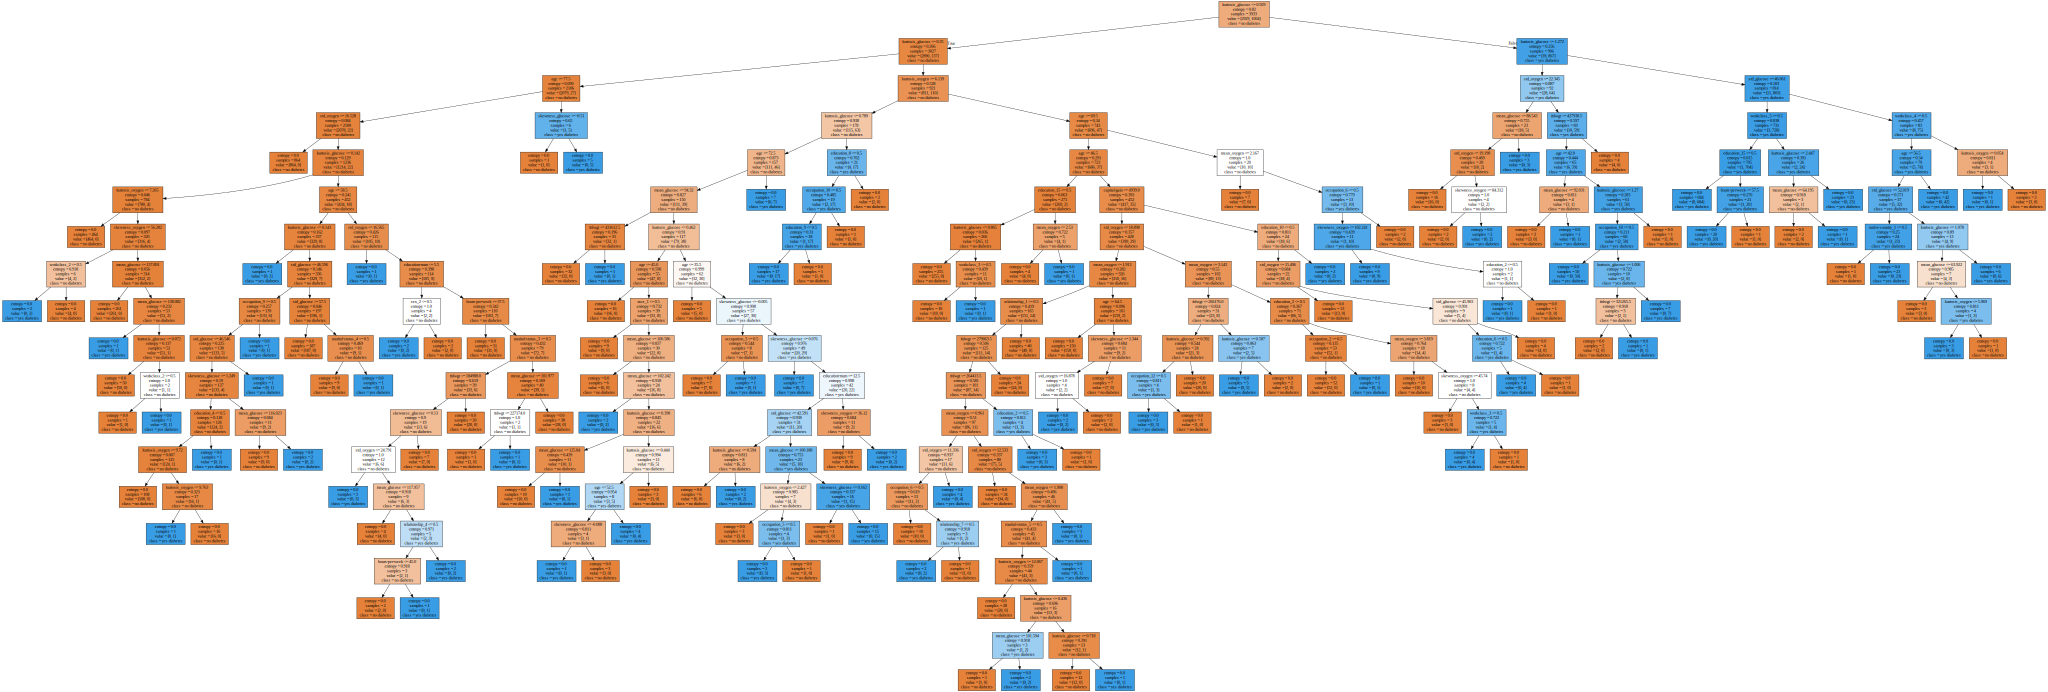

In [18]:
graph = Source(export_graphviz(cls, 
                               out_file=None,
                               feature_names=X.columns,
                               class_names=['no diabetes', 'yes diabetes'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)

In [19]:
val_merged_data = pd.read_csv('validate_datas_KNN.csv',index_col=0)
# val_merged_data.info()
val_merged_data = val_merged_data.drop(['name', 'address', 'date_of_birth'], axis = 1)
categoric = val_merged_data.select_dtypes(include = ['object'])
transformed = encoder.transform(categoric)

val_merged_data = val_merged_data.drop(categoric, axis = 1)
val_merged_data = val_merged_data.merge(transformed, left_index=True, right_index=True)

In [20]:
val_merged_data = val_merged_data.dropna()
val_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1310
Columns: 117 entries, education-num to workclass_7
dtypes: float64(15), int64(102)
memory usage: 1.2 MB


In [21]:
prediction = cls.predict(val_merged_data[val_merged_data.columns.difference(['class'])])

In [22]:
print(classification_report(val_merged_data['class'],prediction, digits=3))

              precision    recall  f1-score   support

         0.0      0.970     0.946     0.958       963
         1.0      0.859     0.919     0.888       346

    accuracy                          0.939      1309
   macro avg      0.915     0.933     0.923      1309
weighted avg      0.941     0.939     0.940      1309



Povodne nahradenie chybajucich hodnot pouzivalo pri nahradzovani numerickych hodnot KNN algoritmus a MissForest s transformerom. Dosiahli sme accuracy 93.8% a precision 91.3%, ale ako by povedal Vranic, "ja nie som odbornik".

Pri strategii, kde sme vyuzili iba KNN algoritmus, dosiahol strom accuracy 93.9% a precission 91.5%. Teda mozeme spozorovat minimalne zlepsenie pri tejto strategii.

Tu pouzivame rovnaku cast. Avsak na nahradzovanie chybajucich hodnot sme pouzili algoritmus mean, bez PowerTransformeru.

In [23]:
merged_data = pd.read_csv('trained_datas_mean.csv',index_col=0)
# merged_data.info()
merged_data = merged_data.drop(['name', 'address', 'date_of_birth'], axis = 1)
categoric = merged_data.select_dtypes(include = ['object'])

encoder = ce.OneHotEncoder()
encoder.fit(categoric)
transformed = encoder.transform(categoric)

merged_data = merged_data.drop(categoric, axis = 1)
merged_data = merged_data.merge(transformed, left_index=True, right_index=True)
merged_data

,education-num,capital-gain,fnlwgt,hours-per-week,capital-loss,kurtosis_glucose,kurtosis_oxygen,mean_glucose,mean_oxygen,skewness_glucose,...,native-country_37,native-country_38,native-country_39,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7
0,14.0,0.0,338816.0,70.0,0.0,1.280503,3.513019,95.351562,14.103679,3.351277,...,0,0,0,1,0,0,0,0,0,0
1,10.0,0.0,194304.0,55.0,0.0,0.267679,8.402489,111.164062,2.902174,-0.141940,...,0,0,0,0,1,0,0,0,0,0
2,10.0,0.0,200700.0,50.0,0.0,0.850184,1.042517,14.460938,57.382107,3.519960,...,0,0,0,0,1,0,0,0,0,0
3,10.0,0.0,132626.0,6.0,0.0,0.510415,10.508914,107.796875,1.910535,1.672603,...,0,0,0,0,1,0,0,0,0,0
4,10.0,0.0,177974.0,70.0,0.0,0.459786,12.595281,111.484375,1.599498,-0.116594,...,0,0,0,0,1,0,0,0,0,0
5,9.0,0.0,81548.0,40.0,0.0,0.981032,5.359597,91.835938,6.798495,2.209713,...,0,0,0,0,1,0,0,0,0,0
6,9.0,0.0,212894.0,40.0,0.0,0.167162,8.173738,112.007812,2.843645,-0.447539,...,0,0,0,0,1,0,0,0,0,0
7,9.0,0.0,99697.0,40.0,0.0,2.102055,5.255796,65.539062,6.836120,9.023275,...,0,0,0,0,1,0,0,0,0,0
8,9.0,0.0,252714.0,30.0,0.0,0.850184,0.969790,22.312500,66.960702,3.519960,...,0,0,0,0,1,0,0,0,0,0
9,9.0,0.0,309630.0,40.0,0.0,0.269218,16.834602,110.406250,1.040134,0.210545,...,0,0,0,0,1,0,0,0,0,0


In [24]:
cls = DecisionTreeClassifier(criterion = 'entropy')

X = merged_data[merged_data.columns.difference(['class'])]
y = merged_data['class']
cls = cls.fit(X, y)

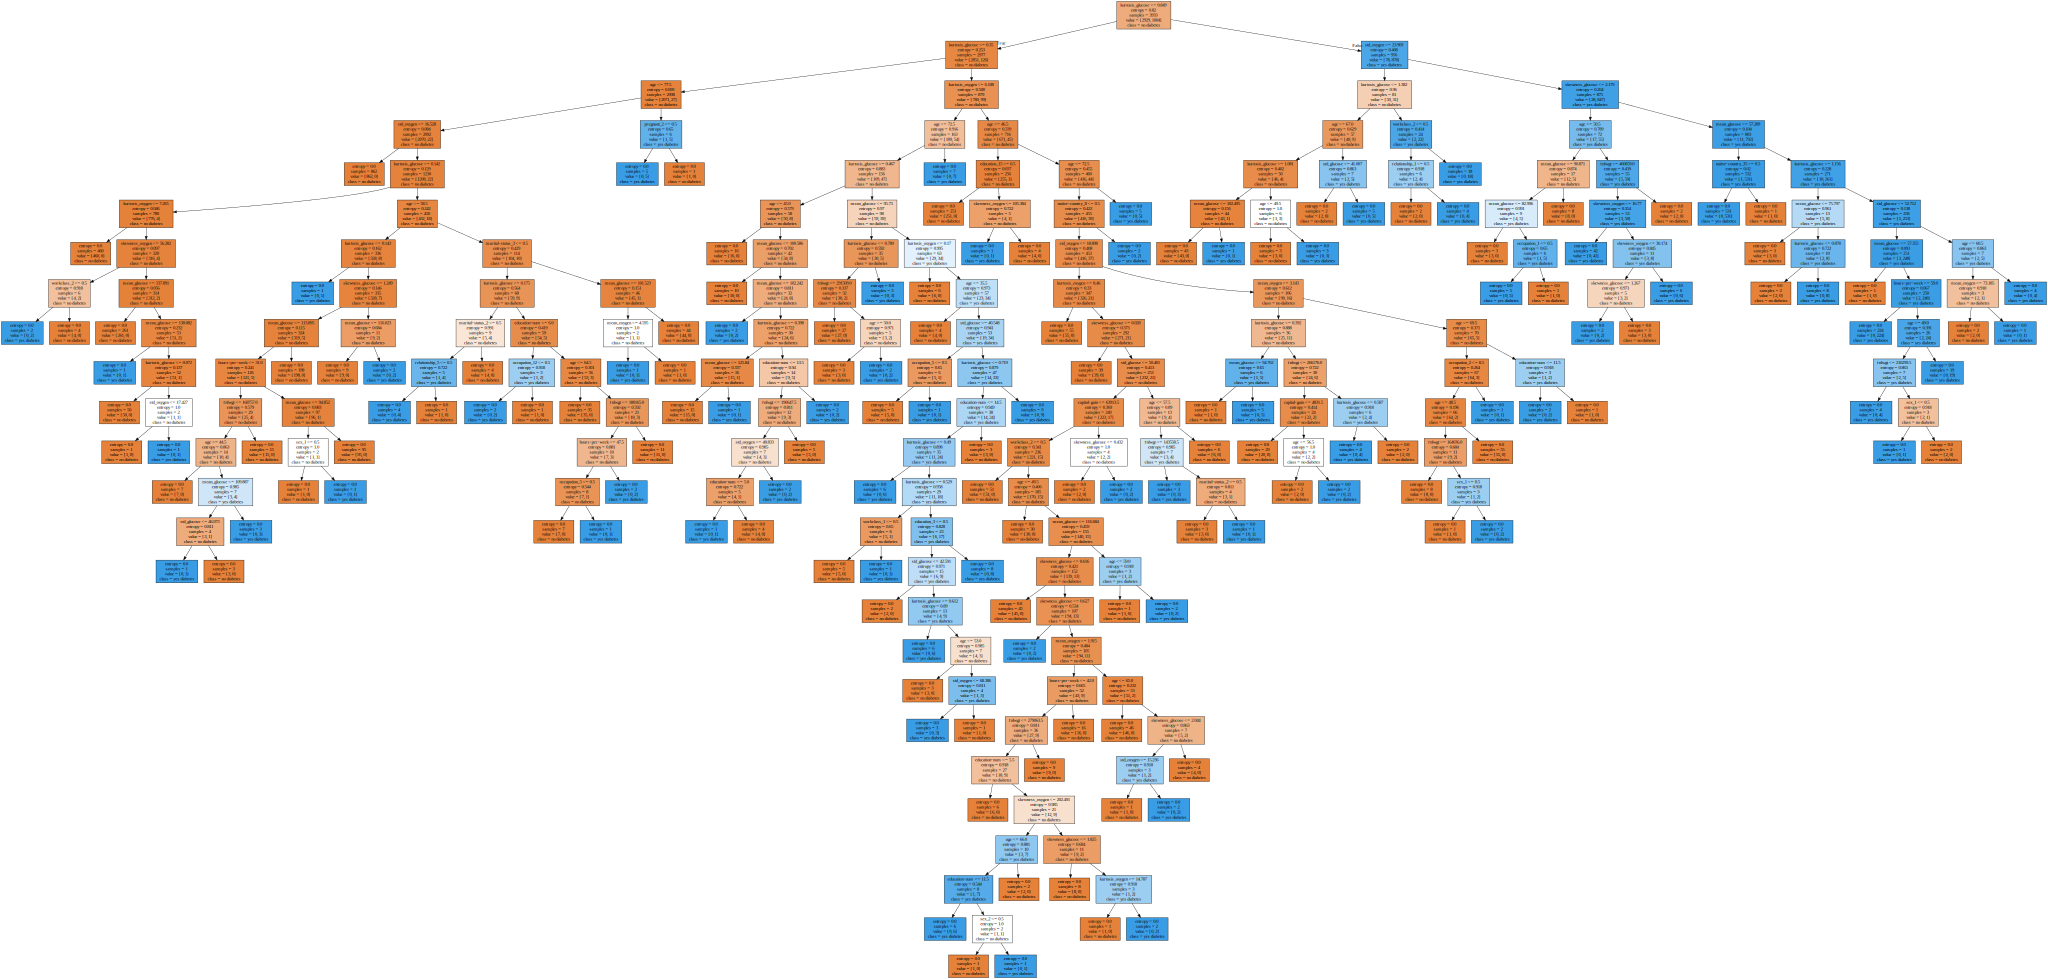

In [25]:
graph = Source(export_graphviz(cls, 
                               out_file=None,
                               feature_names=X.columns,
                               class_names=['no diabetes', 'yes diabetes'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)

In [26]:
val_merged_data = pd.read_csv('validate_datas_mean.csv',index_col=0)
# val_merged_data.info()
val_merged_data = val_merged_data.drop(['name', 'address', 'date_of_birth'], axis = 1)
categoric = val_merged_data.select_dtypes(include = ['object'])
transformed = encoder.transform(categoric)

val_merged_data = val_merged_data.drop(categoric, axis = 1)
val_merged_data = val_merged_data.merge(transformed, left_index=True, right_index=True)

In [27]:
val_merged_data = val_merged_data.dropna()
val_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1310
Columns: 117 entries, education-num to workclass_7
dtypes: float64(15), int64(102)
memory usage: 1.2 MB


In [28]:
prediction = cls.predict(val_merged_data[val_merged_data.columns.difference(['class'])])

In [29]:
print(classification_report(val_merged_data['class'],prediction, digits=3))

              precision    recall  f1-score   support

         0.0      0.971     0.957     0.964       963
         1.0      0.886     0.919     0.902       346

    accuracy                          0.947      1309
   macro avg      0.928     0.938     0.933      1309
weighted avg      0.948     0.947     0.948      1309



Oproti povodnej strategii (accuracy 93.8%, precision 91.3% a recall 93.3%) sme dosiahli lepsie vysledky a to pri vsetkych meritkach, accuracy bolo 94.7%, precision 92.9% a recall 93.7%.

Z toho vyplyva, ze jednoduchsia strategia pre nahradzovanie chybajucich hodnot (mean) dosiahla lepsie vysledky ako komplikovanejsie strategie pouzitim algoritmov umelej inteligencie (KNN a MissForest).